## Figure S7. SHAPE-based pri-miRNA structures
#### data to include
- SHAPE-based pri-miRNA structure
- pri-miRNA features and optimality
- in vitro processing results
- possible cofactors

In [22]:
import time
today = time.strftime('%Y-%m-%d')
name = 'S. Chan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by S. Chan Baek at 2023-10-28.


In [23]:
home = '/casa/bsc/projects/2_Structure-of-pri/2007_paper_prep'
%cd $home

/casa/bsc/projects/2_Structure-of-pri/2007_paper_prep


In [24]:
import sys; sys.path.append('/casa/bsc/notebooks/')
from basic import gen_result_dir
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/231028/


In [25]:
from __future__ import division
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from os import path
import matplotlib
import pandas as pd
import numpy as np
import re
import gzip
from util import *
#%matplotlib inline

### 1) Load data

In [26]:
## processing data
as1 = pd.read_csv('supplementary/TableS1__Previously_identified_DROSHA-dependence.csv', 
                 header=1, index_col=0)
as2 = pd.read_csv('supplementary/TableS2__Oligonucleotides_used_in_this_study.csv',
                 header=1, index_col=0)
as3 = pd.read_csv('supplementary/TableS3__In_vitro_processing_results_\
Microprocessor-only.csv', header=1, index_col=0)
as4 = pd.read_csv('supplementary/TableS4__Cis-acting_elements_of_human_pri-miRNAs.csv', 
                 header=1, index_col=0)
as5 = pd.read_csv('supplementary/TableS5__In_vitro_processing_results_SRSF3.csv', 
                 header=1, index_col=0)

In [27]:
EFFCUT = 1.5
HOMCUT = .25
effsmp = as3['Cleavage Efficiency'].to_dict()
homsmp = as3['Cleavage Homogeneity'].to_dict()
effssr = as5['Cleavage Efficiency'].to_dict()
homssr = as5['Cleavage Homogeneity'].to_dict()
dcsmirsmp = [ m for m in as3.index if effsmp[m]>=EFFCUT and homsmp[m]>=HOMCUT ]
nodcsmp = [ m for m in as3.index if m not in dcsmirsmp ]
dcsmirs = [ m for m in as5.index if effssr[m]>=EFFCUT and homssr[m]>=HOMCUT ]
nodcs = [ m for m in as5.index if m not in dcsmirs ]
ivpmirs = sorted([m for m in as3.index if m in as5.index])
productive = [m for m in ivpmirs if m in dcsmirs or m in dcsmirsmp]
print len(dcsmirsmp), len(dcsmirs), len(productive)

560 747 758


In [31]:
#clvmp = pd.read_csv('../../1_DCS/2004_paper_prep/\
#resources/210111_cleavage_sites.csv',index_col=0)
#clvsr = pd.read_csv('../../1_DCS/2004_paper_prep/\
#resources/210111_cleavage_sites_srsf3.csv',index_col=0)
clvmp = pd.read_csv('../../1_DCS/2004_paper_prep/\
resources/210325_cleavage_sites_inv.csv',index_col=0)
clvsr = pd.read_csv('../../1_DCS/2004_paper_prep/\
resources/210325_cleavage_sites_srsf3_inv.csv',index_col=0)

In [29]:
majorcsmp = {}
for mir in dcsmirsmp:
    c5, c3 = as3.loc[[mir],["5' cleavage site","3' cleavage site"]].iloc[0]
    majorcsmp[mir] = (int(c5),int(c3))
print len(majorcsmp), majorcsmp['hsa-let-7a-1']

560 (25, 96)


In [30]:
majorcs = {}
for mir in dcsmirs:
    c5, c3 = as5.loc[[mir],["5' cleavage site","3' cleavage site"]].iloc[0]
    majorcs[mir] = (int(c5),int(c3))
print len(majorcs), majorcs['hsa-let-7a-1']

747 (25, 96)


In [28]:
## shape data
s1 = pd.read_csv('supplementary/211228_s1_pri-info.csv',header=1,index_col=0)
s2 = pd.read_csv('supplementary/211228_s2_construct.csv',header=1,index_col=0)
constseqs = s2['construct sequence'].to_dict()
features = pd.read_csv('shape/2021-12-28/231027_features.csv',index_col=0)
folded = list(features.index)
features.iloc[:3,:12]

,stem,upper stem,lower stem,BJ5,BJ3,AJ5,AJ3,BS5,BS3,BE5,BE3,loop
hsa-let-7a-1,34.0,21.0,13.0,11.0,109.0,46.0,74.0,2.0,7.0,8.0,117.0,27.0
hsa-let-7a-2,36.0,22.0,14.0,13.0,106.0,49.0,71.0,6.0,9.0,6.0,116.0,21.0
hsa-let-7a-3,35.0,21.0,14.0,12.0,107.0,47.0,72.0,3.0,4.0,8.0,112.0,24.0


In [32]:
def get_pre_position(mir):
    constseq = constseqs[mir].replace('T','U')
    preseq = s1.loc[mir, 'precursor']
    return constseq.find(preseq)+1, constseq.find(preseq)+len(preseq)

In [12]:
# def get_pre_position(mir):
#     flank5, flank3 = as2.loc[mir,["5' flanking segment","3' flanking segment"]]
#     if flank5 or flank3:
#         return (len(flank5)+1,125-len(flank3))
#     else:
#         return (0,126)

In [33]:
def split_ct(ctfile):
    infos = open(ctfile, 'rt').read()
    rna = infos.split('\n')[0].strip().split()[-1]
    nstrt = infos.count(rna)
    splitinfos = []
    for i in range(nstrt):
        lines = infos.split('\n')[1+(1+len(constseqs[rna]))*i:(1+len(constseqs[rna]))*(i+1)]
        splitinfos.append([ tuple(map(int,l.strip().split()[4:6][::-1])) for l in lines ])
    return splitinfos

In [34]:
primat = {}
for pri, row in annpri.iterrows():
    matureDerives = anntbl[anntbl['Derives_from']==row['ID']]
    primat[pri] = matureDerives['ID'].tolist()
print primat['hsa-mir-320a']

['MIMAT0000510']


In [36]:
ugrange = range(-20,-9)
uglist = defaultdict(list)
ugposes = {}
for m in folded:
    if m in dcsmirs:
        ps, pe = majorcs[m]
    elif m in dcsmirsmp:
        ps, pe = majorcsmp[m]
    else:
        ps, pe = get_pre_position(m)
        
    priseq = constseqs[m].replace('T','U')
    lstems = [(i,p) for i,p in split_ct(features.loc[m,'ct file'])[0] if i<ps]
    consecps = zip(lstems[:-1],lstems[1:])
    symstr = features.loc[m,'structure']
    for (i1,p1),(i2,p2) in consecps:
        if 0<p1<60 or 0<p2<60:
            continue
        
        firstm = symstr[i1-1:].find('M')
        pos = -1*(count_len(symstr[i1-1+firstm:ps-1])+firstm)
        if pos not in ugrange:
            continue
        
        if priseq[i1-1:i2]=='UG':
            uglist[pos].append(m)
            if pos==-14:
                ugposes[m] = range(i1,i2+1)
ugmirs = set(uglist[-14])
print len(ugmirs), ugposes['hsa-mir-16-1']

 108 [15, 16]


In [37]:
ugurange = range(16,27)
ugulist = defaultdict(list)
uguposes = defaultdict(list)
for m in folded:
    if m in dcsmirs:
        ps, pe = majorcs[m]
    elif m in dcsmirsmp:
        ps, pe = majorcsmp[m]
    else:
        ps, pe = get_pre_position(m)
        
    aj5,aj3 = features.loc[m,['AJ5','AJ3']].astype(int)
    priseq = constseqs[m].replace('T','U')
    ustems = [(i,p) for i,p in split_ct(features.loc[m,'ct file'])[0] if ps<=i<aj3]
    symstr = features.loc[m,'structure']
    symstr = symstr[:aj5]+'L'*(aj3-aj5-1)+symstr[aj3-1:]
    for i1,p1 in ustems:        
        firstm = symstr[:i1].rfind('M')
        pos = count_len(symstr[ps-1:firstm])+(i1-firstm)
        if pos not in ugurange:
            continue
        
        if priseq[i1-1:i1+2] in ['UGU','GUG']:
            ugulist[pos].append(m)
            if pos in range(20,25):
                uguposes[m].extend([p for p in range(i1,i1+3) if p not in uguposes[m]])
ugumirs = set(ugulist[20]+ugulist[21]+ugulist[22]+ugulist[23]+ugulist[24])
print len(ugumirs), uguposes['hsa-mir-30a']

200 [53, 54, 55, 56]


In [38]:
scotbl = pd.ExcelFile('supplementary/Kwon_2018_s4.xlsx')\
.parse('DODGERS scores',header=5,index_col=2)
def matching_bases(st, en, symstr):
    str5p = symstr[st-1:]
    str3p = symstr[:en][::-1]
    i,j = 0,0
    match = {}
    while i<len(str5p) and j<len(str3p):
        if str5p[i]=='L' or str3p[j]=='L':
            break
        if str5p[i]!='A' and str3p[j]!='A':
            match[i]=j; i+=1; j+=1
        elif str5p[i]=='A':
            i+=1
        elif str3p[j]=='A':
            j+=1
    return {i+st:en-j for i,j in match.items()}

def get_ghgs(mir):
    symstr = features.loc[mir,'structure']
    bjs = symstr.find('M')+1
    bje = symstr.rfind('M')+1
    matches = matching_bases(bjs,bje,symstr)
    priseq = constseqs[mir].replace('T','U')
    if mir in dcsmirs:
        ps, pe = majorcs[mir]
    elif mir in dcsmirsmp:
        ps, pe = majorcsmp[mir]
    else:
        ps, pe = get_pre_position(mir)
        
    if len(matches)<3:
        return {}
    end = sorted(matches.keys())[-3]
    ghgs, ghgpos = {}, []
    for st in range(bjs,end+1):
        if st not in matches:
            continue
        if all([((st+i),(matches[st]-i)) in matches.items() for i in range(3)]):
            if st<ps:
                pos = -count_len(symstr[st-1:ps-1])
            else:
                pos = count_len(symstr[ps-1:st-1])
            ghg5p = priseq[st-1:st+2]
            ghg3p = priseq[matches[st]-3:matches[st]][::-1]
            ghgseq = ghg5p+ghg3p
            ghgs[pos+1] = scotbl.loc[ghgseq,'DODGERS score']
            if pos==-7:
                ghgpos = range(st,st+3)+range(matches[st]-2,matches[st]+1)
    return ghgs, ghgpos

In [39]:
ghgtbl = {}
ghgposes = {}
for mir in folded:
    ghg, ghgpos = get_ghgs(mir)
    ghgtbl[mir] = ghg
    ghgposes[mir] = ghgpos
ghgtbl = pd.DataFrame(ghgtbl).T
ghgmirs = list(ghgtbl[ghgtbl[-6]>=38].index)
print len(ghgmirs), ghgposes['hsa-mir-125a']

242 [24, 25, 26, 93, 94, 95]


In [40]:
def find_cnnc(mir, cnnc):
    if mir in dcsmirs:
        ps, pe = majorcs[mir]
    elif mir in dcsmirsmp:
        ps, pe = majorcsmp[mir]
    else:
        ps, pe = get_pre_position(mir)
    cnncseq = constseqs[mir][pe+15:pe+21]
    cnncfind = re.search(cnnc, cnncseq)
    if cnncfind:
        return range(cnncfind.start()+pe+16,cnncfind.start()+pe+20)
    return []

In [41]:
cnncmirs = [m for m in folded if find_cnnc(m,'C..C')]
cnncposes = {m:find_cnnc(m,'C..C') for m in folded}
print len(cnncmirs), cnncposes['hsa-mir-125a']

297 [106, 107, 108, 109]


In [42]:
gwgmirs = ['hsa-mir-3140',
 'hsa-mir-424',
 'hsa-mir-486-1',
 'hsa-mir-98',
 'hsa-mir-99a',
 'hsa-mir-1247',
 'hsa-mir-1271',
 'hsa-mir-183',
 'hsa-mir-2115']
gwgposes = {'hsa-mir-3140':[103,104,105],
            'hsa-mir-424':[98,99,100],
            'hsa-mir-486-1':[101,102,103],
            'hsa-mir-98':[108,109,110],
            'hsa-mir-99a':[97,98,99],
            'hsa-mir-1247':[100,101,102],
            'hsa-mir-1271':[97,98,99],
            'hsa-mir-183':[100,101,102],
            'hsa-mir-2115':[100,101,102]}

### 2) processing table

In [43]:
def filter_na(v):
    if np.isnan(v):
        return 'n.d'
    return '%.0f%%'%(v*100)

In [44]:
def narank(v):
    if np.isnan(v):
        return 'n.d'
    return int(v)

In [45]:
enorm = effsmp['hsa-mir-30a']
hnorm = homsmp['hsa-mir-30a']

In [46]:
sub = as3[['Cleavage Efficiency','Cleavage Homogeneity']].reindex(folded)
sub['eff_rank'] = sub['Cleavage Efficiency'].rank(ascending=False,method='max').astype(int)
sub['hom_rank'] = sub['Cleavage Homogeneity'].rank(ascending=False,method='max').astype(int)
sub['Cleavage Efficiency'] = (sub['Cleavage Efficiency']/enorm).round(2)
sub['Cleavage Homogeneity'] = (sub['Cleavage Homogeneity']/hnorm).round(2)
sub.head(5)

,Cleavage Efficiency,Cleavage Homogeneity,eff_rank,hom_rank
Pri-miRNA,,,,
hsa-let-7a-1,1.41,1.12,22,30
hsa-let-7a-2,1.14,1.00,107,93
hsa-let-7a-3,0.61,0.63,322,266
hsa-let-7b,1.05,0.98,148,107
hsa-let-7c,0.00,0.15,476,412


In [49]:
su2 = as5[['Cleavage Efficiency','Cleavage Homogeneity']].reindex(folded)
su2['eff_rank'] = su2['Cleavage Efficiency'].rank(ascending=False,method='max').astype(int)
su2['hom_rank'] = su2['Cleavage Homogeneity'].rank(ascending=False,method='max').astype(int)
su2['Cleavage Efficiency'] = (su2['Cleavage Efficiency']/enorm).round(2)
su2['Cleavage Homogeneity'] = (su2['Cleavage Homogeneity']/hnorm).round(2)
su2.head(5)

,Cleavage Efficiency,Cleavage Homogeneity,eff_rank,hom_rank
Pri-miRNA,,,,
hsa-let-7a-1,2.22,1.11,19,57
hsa-let-7a-2,2.02,0.97,70,173
hsa-let-7a-3,1.22,0.81,377,288
hsa-let-7b,1.90,0.96,122,189
hsa-let-7c,1.61,0.85,261,264


In [47]:
#cmap = matplotlib.cm.get_cmap('RdYlBu')
cmap = custom_cmap(['#de2d26','#f0f0f0','#f0f0f0','#3182bd'])
cmap2 = custom_cmap(['#3182bd','#f0f0f0','#f0f0f0','#de2d26'])
cmap(0.8)

(0.49176470588235294, 0.6823529411764706, 0.8211764705882353, 1.0)

In [50]:
index = ['cleavage\nefficiency','cleavage\nhomogeneity']
columns = ['w/o SRSF3','w/ SRSF3']
items = ['Cleavage Efficiency','eff_rank','Cleavage Homogeneity','hom_rank']

dataall = {}
colorall = {}
for m in folded:
    data = pd.DataFrame(columns=columns,index=index)
    eff,effr,hom,homr = sub.loc[m,items]
    ef2,ef2r,ho2,ho2r = su2.loc[m,items]
    cs, cs2 = [], []
    
    data.loc['cleavage\nefficiency','w/o SRSF3'] = '%s\n(%i / %i)'%(eff,effr,len(folded))
    data.loc['cleavage\nhomogeneity','w/o SRSF3'] = '%s\n(%i / %i)'%(hom,homr,len(folded))
    data.loc['cleavage\nefficiency','w/ SRSF3'] = '%s\n(%i / %i)'%(ef2,ef2r,len(folded))
    data.loc['cleavage\nhomogeneity','w/ SRSF3'] = '%s\n(%i / %i)'%(ho2,ho2r,len(folded))
    cs.extend(map(cmap,[effr/len(folded),homr/len(folded)]))
    cs2.extend(map(cmap,[ef2r/len(folded),ho2r/len(folded)]))
    
    dataall[m] = data
    colorall[m] = zip(cs,cs2)
dataall['hsa-let-7a-1']

,w/o SRSF3,w/ SRSF3
cleavage\nefficiency,1.41\n(22 / 476),2.22\n(19 / 476)
cleavage\nhomogeneity,1.12\n(30 / 476),1.11\n(57 / 476)


In [51]:
## name
mirnames = {}
for m in folded:
    name = m.replace('hsa-','pri-')
    #name = name[0].upper()+name[1:]
#     if m in productive:
#         name = '%s ("processed")'%name
#     else:
#         name = '%s ("failed")'%name
    mirnames[m] = name
print mirnames['hsa-let-7a-1']

pri-let-7a-1


In [52]:
## coordinate
coords = {}
for m in ivpmirs:
    ch,st,en,strand = as2.loc[m,['Chr','Start','End','Strand']]
    coords[m] = '%s: %s-%s (%s)'%(ch,st,en,strand)
print coords['hsa-let-7a-1']

chr9: 94175938-94176062 (+)


In [53]:
## conservation
def get_phylop_scores(chrom, start, end, path):
    phystarts = [ int(f.split('.')[0]) for f in listdir('%s/%s'%(path, chrom)) 
                  if f.endswith('.gz') ]
    init = sorted([ s for s in phystarts if s<=start ])[-1]
    if start<max(phystarts):
        nextst = sorted([ s for s in phystarts if s>start])[0]
    else: nextst = end
    rels, rele = start-init, end-init
    phys = open('%s/%s/%s.phylop.gz'%(path, chrom,init), 'rt').read().strip().split('\n')
    if len(phys) <= rels:
        if nextst >= end:
            return ['-']*(end-start+1)
        else:
            return ['-']*(nextst-start) + get_phylop_scores(chrom, nextst, end)
    elif len(phys) > rele:
        return map(float, phys[rels:rele+1])
    else: # rels < len(phys) <= rele
        return map(float, phys[rels:]) + get_phylop_scores(chrom, init+len(phys), end)
    
def get_mature_conserv(pri, path):
    mats = primat[pri]
    matcons = []
    for mat in mats:
        ch, st, en = annmat.loc[mat,['chr','start','end']]
        cons = [ c for c in get_phylop_scores(ch, st, en, path) if c!='-' ]
        if cons:
            matcons.append(np.average(cons))
    if matcons:
        return max(matcons)
    return -999

path100 = '/casa/bsc/databases/human/phyloP100way'
matcons100 = { p:get_mature_conserv(p,path100) for p in ivpmirs}

In [54]:
med = np.median([matcons100[m] for m in s1.index if m in ivpmirs])
constext = {m:'%.1f (median of MirGeneDB: %.1f)'%(matcons100[m],med) for m in ivpmirs}
print constext['hsa-let-7a-1']

8.0 (median of MirGeneDB: 2.4)


In [45]:
## expression
exptbl = pd.read_table('../../1_DCS/2004_paper_prep/\
supplementary/RNAAtlas_miRNA_rpm_filtered.txt',sep='\t')
exptbl = exptbl[exptbl['MIMAT_id'].apply(lambda x: x in annmat.index)]
exptbl['Name'] = exptbl['MIMAT_id'].apply(lambda x:annmat.loc[x,'Name'])
exptbl = exptbl.set_index('Name')
exptbl = exptbl.drop(['MIMAT_id','genome_coordinates'],axis=1)

def get_mature_exp(pri):
    mats = primat[pri]
    matexp = []
    for mat in mats:
        matname = annmat.loc[mat,'Name']
        if matname in exptbl.index:
            matexp.append(exptbl.loc[matname].tolist())
    if matexp:
        return max(matexp,key=lambda x:np.average(x))
    return [0]

matexp = { p:get_mature_exp(p) for p in ivpmirs }

In [46]:
med = np.median([np.average(matexp[m]) for m in s1.index if m in ivpmirs])
exptext = {m:'%.0f (median of MirGeneDB: %.0f)'%(np.average(matexp[m]),med) for m in ivpmirs}
print exptext['hsa-let-7a-1']

59365 (median of MirGeneDB: 38)


In [125]:
## cluster
BEDCOLS = 'chr start end mir . strand'.split()
gencsv = '/casa/bsc/databases/miRNA/annotation/hg38_hsa_hairpin.bed'
gentbl = pd.read_table(gencsv, sep='\t', names=BEDCOLS).set_index('mir')

def find_neighbor_mir(mir):
    chrom, start, end, strand = gentbl.loc[mir,['chr','start','end','strand']]
    samechr = [ m for m in ivpmirs if gentbl.loc[m,'chr']==chrom and m!=mir
            and min(abs(start-gentbl.loc[m,'end']),abs(end-gentbl.loc[m,'start']))<=10**4 ]
    dists = []
    for m in samechr:
        st, en, strd = gentbl.loc[m,['start','end','strand']]
        if strand=='+':
            if st<start:
                relpos = r'$\minus$%s'%max(start-en,0)
            else:
                relpos = '+%s'%max(st-end,0)
        else:
            if st<start:
                relpos = '+%s'%max(start-en,0)
            else:
                relpos = r'$\minus$%s'%max(st-end,0)
        if strd==strand:
            dists.append(relpos)
        else:
            dists.append(relpos+' AS')
    return zip(samechr,dists)

neighbors = {m:find_neighbor_mir(m) for m in ivpmirs}
print neighbors['hsa-mir-15a']

KeyboardInterrupt: 

In [ ]:
clsttext = {m:'\n'.join(['    %s [relative pos: %s]'%(mirnames[nei],dist)
                         for nei,dist in neighbors[m]]) for m in folded}
print clsttext['hsa-mir-15a']

In [ ]:
## in vivo study
invivo = {}
for m in ivpmirs:
    note = as1.loc[m,'DROSHA dependency']
    if m=='hsa-mir-451a':
        invivo[m] = 'DICER-independent'
    elif 'DROSHA' in note:
        invivo[m] = note.split('dent, ')[1].replace('verified','validated')
    else:
        invivo[m] = ''
print invivo['hsa-let-7a-1']

(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

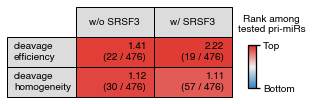

In [55]:
m = 'hsa-let-7a-1'
fig, ax = plt.subplots(1,1,figsize=(1.4,1))
data = dataall[m]

table = ax.table(cellText=data.values,colLabels=columns,rowLabels=index,loc='center',
    colWidths=[1,1,1],rowColours=['#dcdcdc']*len(index),colColours=['#dcdcdc']*len(columns),
    cellColours=colorall[m])

axtmp = fig.add_axes([0,0,.01,.01])
im = axtmp.pcolor([[0,1]],cmap=cmap2); axtmp.set_visible(False)
axcb = fig.add_axes([1.45,0,.08,.6])
cb = plt.colorbar(im, cax=axcb)
cb.set_ticks([0,1]); cb.set_ticklabels(['Bottom','Top'])
cb.ax.tick_params(labelsize=10)
cb.solids.set_rasterized(True)
axcb.text(2.9, 1.3, 'Rank among\ntested pri-miRs',fontsize=10,ha='center')

ax.set_xlim(0,10); ax.set_ylim(0,10)
table.scale(1,2.5)
ax.axis('tight'); ax.axis('off')
#fig.savefig(resultpath + 'test4.eps')
#plt.close()

In [69]:
uppath = '/casa/bsc/projects/2_Structure-of-pri/2007_paper_prep/shape/2021-12-28'
infopath = '%s/231027/'%uppath
if not path.exists(uppath):
    !mkdir $uppath
if not path.exists(infopath):
    !mkdir $infopath

In [37]:
for m in folded:
    fig, ax = plt.subplots(1,1,figsize=(1.3,1))
    data = dataall[m]
    table = ax.table(cellText=data.values,colLabels=columns,rowLabels=index,loc='center',
        colWidths=[1,1,1],rowColours=['#dcdcdc']*len(index),
        colColours=['#dcdcdc']*len(columns),cellColours=colorall[m])
    ax.set_xlim(0,10); ax.set_ylim(0,10)
    
    axtmp = fig.add_axes([0,0,.01,.01])
    im = axtmp.pcolor([[0,1]],cmap=cmap2); axtmp.set_visible(False)
    axcb = fig.add_axes([1.45,0,.08,.6])
    cb = plt.colorbar(im, cax=axcb); cb.solids.set_rasterized(True)
    cb.set_ticks([0,1]); cb.set_ticklabels(['Bottom','Top']); cb.ax.tick_params(labelsize=10)
    axcb.text(2.9, 1.3, 'Rank among\nall pri-miRs',fontsize=10,ha='center')
    table.scale(1,2.5)
    ax.axis('tight'); ax.axis('off')
    fig.savefig(infopath + '%s_processing.eps'%m.replace('hsa-',''))
    plt.close()

### 3) SHAPE table

In [59]:
s4 = pd.read_csv('supplementary/231027_s4_features.csv',index_col=0)
s4.head(1)

,Stem length,Lower stem length,Upper stem length,Mismatch count,Bulge count,Apical loop size,5' basal segment length,3' basal segment length,mismatch at -6,3p bulge at -10
hsa-let-7a-1,34,13,21,0,4,27,2,7,0.0,2.0


In [60]:
s4drop = s4.drop(["5' basal segment length",'Upper stem length','3p bulge at -10',
              'mismatch at -6'],axis=1)

In [64]:
s5 = pd.read_csv('supplementary/221110_ml.csv',index_col=0).iloc[:,:8]
s5['mm'] = (s5['mm']-1)*10
s5['bg3'] = (s5['bg3']-1)*10
s5.head(3)

,stem,lower stem,mismatch,mm,bulged,bg3,loop,basal segment
hsa-let-7a-1,2,2,2,-10,1,10,2,2
hsa-let-7a-2,2,1,0,-10,2,-10,2,2
hsa-let-7a-3,2,1,2,-10,1,-10,2,2


In [62]:
encoding = {2:'Optimal',1:'Suboptimal',0:'Poor',-10:'',10:''}
encoding2 = {0:'Not possessed',2:'Possessed'}

In [89]:
features.head(1)

,stem,upper stem,lower stem,BJ5,BJ3,AJ5,AJ3,BS5,BS3,BE5,BE3,loop,Mismatch,Bulge,ct file,structure
hsa-let-7a-1,34.0,21.0,13.0,11.0,109.0,46.0,74.0,2.0,7.0,8.0,117.0,27.0,0.0,4.0,shape/2021-12-28/figures/hsa-let-7a-1_rep2-1_m...,MMMMMMMMSSMMMMMMMAMMMMMMAMMMMMMMMMMMMMMMMMMMMM...


In [90]:
shtbl.index

Index([u'Stem length', u'Lower stem length', u'Mismatch count', u'Bulge count',
       u'Apical loop size', u'3' basal segment length', u'Mismatch at -6',
       u'bGWG bulge at -10/-11'],
      dtype='object')

In [91]:
shdata = {}
for m in folded:
    shtbl = s4drop.reindex([m]).T#.drop(["5' basal segment length",'Upper stem length'])
    shtbl.loc['Mismatch at -6',m] = encoding2[int(s4.loc[m,'mismatch at -6'])]
    #shtbl.loc['3p bulge at -10',m] = encoding2[int(shtbl.loc['3p bulge at -10',m])]
    shtbl.loc['bGWG bulge at -10/-11',m] = encoding2[int(m in gwgmirs)*2]
    steml,lsteml,mmcnt,bgcnt,loopl,bsl = features.loc[m,['stem','lower stem','Mismatch','Bulge','loop','BS3']].astype(int)
    if 34<=steml<=36:
        shtbl.loc['Stem length','Optimality'] = 'Optimal'
    else:
        shtbl.loc['Stem length','Optimality'] = 'Suboptimal'
        
    if lsteml==13:
        shtbl.loc['Lower stem length','Optimality'] = 'Optimal'
    else:
        shtbl.loc['Lower stem length','Optimality'] = 'Suboptimal'
        
    if mmcnt<=1:
        shtbl.loc['Mismatch count','Optimality'] = 'Optimal'
    else:
        shtbl.loc['Stem length','Optimality'] = 'Suboptimal'
        
    if bgcnt<=1:
        shtbl.loc['Bulge count','Optimality'] = 'Optimal'
    else:
        shtbl.loc['Stem length','Optimality'] = 'Suboptimal'
        
    if loopl>=13:
        shtbl.loc['Apical loop size','Optimality'] = 'Optimal'
    else:
        shtbl.loc['Apical loop size','Optimality'] = 'Suboptimal'
        
    if bsl>=5:
        shtbl.loc["3' basal segment length",'Optimality'] = 'Optimal'
    else:
        shtbl.loc["3' basal segment length",'Optimality'] = 'Suboptimal'
    
    #for f1,f2 in zip(shtbl.index,['stem','lower stem','mismatch','bulged','loop','basal segment']):        
    #    shtbl.loc[f1,'Optimality'] = encoding[s5.loc[m,f2]]
    shdata[m] = shtbl.fillna('')

In [92]:
columns = ['Features','Optimality']
rows = ['Stem length (bp)','Lower stem length\n(bp)','Mismatched pairs\nin the stem',
        'Bulged bases\nin the stem','Apical loop size (nt)',
        "3' basal segment\nlength (nt)",'Mismatch at -6','bGWG at -10/-11']

(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

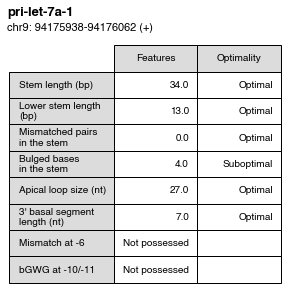

In [67]:
m = 'hsa-let-7a-1'
fig, ax = plt.subplots(1,1,figsize=(1.5,1.5))
data = shdata[m]
table = ax.table(cellText=data.values,colLabels=columns,rowLabels=rows,loc='center',
    colWidths=[1,1,1],rowColours=['#dcdcdc']*len(rows),colColours=['#dcdcdc']*len(columns))
ax.text(-.25,.2,mirnames[m],fontsize=13,weight='bold')
ax.text(-.25,.18,coords[m],fontsize=11)
table.scale(1,2.2)
ax.axis('tight'); ax.axis('off')
#fig.savefig(resultpath + 'test4.eps')
#plt.close()

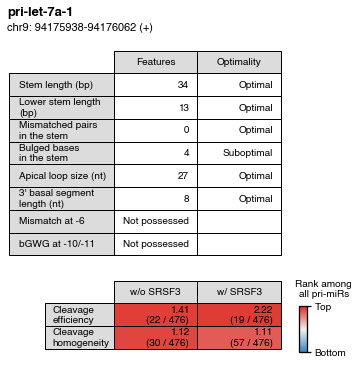

In [126]:
m = 'hsa-let-7a-1'
fig, (ax,ax2) = plt.subplots(2,1,figsize=(1.5,4.3))
data = shdata[m].values
for i in range(6):
    data[i] = np.array([int(data[i][0]),data[i][1]])
table = ax.table(cellText=data,colLabels=columns,rowLabels=rows,loc='center',
 colWidths=[1,1,1],rowColours=['#dcdcdc']*len(rows),colColours=['#dcdcdc']*len(columns))
ax.text(-.25,.21,mirnames[m],fontsize=13,weight='bold')
ax.text(-.25,.187,coords[m],fontsize=11)
table.scale(1,2.8)
ax.axis('tight'); ax.axis('off')

data = dataall[m]
table = ax2.table(cellText=data.values,colLabels=['w/o SRSF3','w/ SRSF3'],
    rowLabels=['Cleavage\nefficiency','Cleavage\nhomogeneity'],loc='center',
    colWidths=[1,1,1],rowColours=['#dcdcdc']*len(index),
    colColours=['#dcdcdc']*len(columns),cellColours=colorall[m])

axtmp = fig.add_axes([0,0,.01,.01])
im = axtmp.pcolor([[0,1]],cmap=cmap2); axtmp.set_visible(False)
axcb = fig.add_axes([1.45,.12,.08,.15])
cb = plt.colorbar(im, cax=axcb); cb.solids.set_rasterized(True)
cb.set_ticks([0,1]); cb.set_ticklabels(['Bottom','Top']); cb.ax.tick_params(labelsize=10)
axcb.text(2.9, 1.2, 'Rank among\nall pri-miRs',fontsize=10,ha='center')
table.scale(1,2.8)
ax2.axis('tight'); ax2.axis('off')
fig.subplots_adjust(hspace=1.25)

In [93]:
for m in folded:
    fig, (ax,ax2) = plt.subplots(2,1,figsize=(1.5,4.3))
    data = shdata[m].values
    for i in range(6):
        data[i] = np.array([int(data[i][0]),data[i][1]])
    table = ax.table(cellText=data,colLabels=columns,rowLabels=rows,loc='center',
     colWidths=[1,1,1],rowColours=['#dcdcdc']*len(rows),colColours=['#dcdcdc']*len(columns))
    ax.text(-.25,.21,mirnames[m],fontsize=13,weight='bold')
    ax.text(-.25,.187,coords[m],fontsize=11)
    table.scale(1,3)
    ax.axis('tight'); ax.axis('off')

    data = dataall[m]
    table = ax2.table(cellText=data.values,colLabels=['w/o SRSF3','w/ SRSF3'],
        rowLabels=['Cleavage\nefficiency','Cleavage\nhomogeneity'],loc='center',
        colWidths=[1,1,1],rowColours=['#dcdcdc']*len(index),
        colColours=['#dcdcdc']*len(columns),cellColours=colorall[m])

    axtmp = fig.add_axes([0,0,.01,.01])
    im = axtmp.pcolor([[0,1]],cmap=cmap2); axtmp.set_visible(False)
    axcb = fig.add_axes([1.45,.12,.08,.15])
    cb = plt.colorbar(im, cax=axcb); cb.solids.set_rasterized(True)
    cb.set_ticks([0,1]); cb.set_ticklabels(['Bottom','Top']); cb.ax.tick_params(labelsize=10)
    axcb.text(2.9, 1.21, 'Rank among\ntested pri-miRs',fontsize=10,ha='center')
    table.scale(1,3)
    ax2.axis('tight'); ax2.axis('off')
    fig.subplots_adjust(hspace=1.25)
    
    fig.savefig(infopath + '%s_combine.eps'%m.replace('hsa-',''))
    plt.close()

### 4) Show cleavage site

In [72]:
import math

In [73]:
def get_angle(x0,y0,x,y):
    if x==x0:
        return math.pi/2
    if x0<x and y0<=y:
        return math.atan((y-y0)/(x-x0))
    if x0<x and y0>y:
        return math.atan((y-y0)/(x-x0))+2*math.pi
    return math.atan((y-y0)/(x-x0))+math.pi

In [74]:
def calculate_stem_angle(coord):
    angles = []
    poses = sorted(coord.keys())
    for p1,p2 in zip(poses[:-1],poses[1:]):
        if p1<60:
            x0,y0 = coord[p1]
            x,y = coord[p2]
        else:
            x0,y0 = coord[p2]
            x,y = coord[p1]   
        angles.append(round(get_angle(x0,y0,x,y),2))
    angle = sorted(Counter(angles).items(), key=lambda x:x[1], reverse=True)[0][0]
    return angle # radian

In [75]:
def get_coordinate_dict(lines):
    posd = {}
    for i, l in enumerate(lines):
        if l.startswith('% nucleotide'):
            pos = int(l.split()[2])-2
            x, y = map(float, lines[i+2].split()[:2])
            posd[pos] = (x+3.5, y+3.5) # center of character
    return posd

In [76]:
def erase_numbers(lines):
    flag = 1
    nlines = []
    for l in lines:
        if flag > 0:
            nlines.append(l)
        if l == '0 0 0 setrgbcolor':
            flag -= 1
        if flag <= 0 and l == 'newpath':
            flag += 999
    return nlines

In [77]:
def get_final_coord(lines):
    x, y = 0,0
    for l in rlines:
        if 'translate' in l:
            x+=float(l.split()[0])
            y+=float(l.split()[1])
    return x,y

In [78]:
def insert_info(info, angle, lines, mir):
    boxline = [l for l in lines if l.startswith('%%BoundingBox')][0]
    xi,yi,xf,yf = map(int, boxline.split(':')[1].strip().split())    
    
    nlines = [l for l in lines if '(%s)'%mir not in l]
    fx, fy = get_final_coord(nlines)
    if angle<=math.pi/4 or math.pi*3/4<=angle<=math.pi*5/4 or angle>=math.pi*7/4: # top
        mx = 0
        my = yf+50
        nboxline = '%%BoundingBox: '+'%s %s %s %s'%(xi-70,yi-40,xf+30,yf+450)
    else: # left
        mx = -430
        my = yf-400
        nboxline = '%%BoundingBox: '+'%s %s %s %s'%(xi-450,yi-20,xf+60,yf+50)
    p1 = nlines.index(boxline)
    nlines = nlines[:p1]+[nboxline]+nlines[p1+1:]
    
    infolines = open(info,'rt').read().split('\n')
    infolines = [l for l in infolines if 'BoundingBox' not in l]
    p2 = [i+1 for i in range(len(infolines)) if 'mpldict begin' in infolines[i]][1]
    infolines = infolines[:p2]+['%s %s translate'%(-fx+mx,-fy+my)]+infolines[p2+1:]
    return nlines + infolines

In [79]:
def get_rgb(s):
    hex2int = [ int(s[2*i+1:2*i+3], 16) for i in range(3) ]
    return ' '.join([ str(round(n/256, 3)) for n in hex2int ]) + ' setrgbcolor'

In [80]:
def draw_arrowhead_v1(point, angle):
    xm,ym = point
    sin, cos = math.sin(angle), math.cos(angle)
    xi = xm - 3*sin - 4*cos
    yi = ym + 3*cos - 4*sin
    xf = xm + 3*sin - 4*cos
    yf = ym - 3*cos - 4*sin
    line = '%.2f %.2f moveto %.2f %.2f lineto %.2f %.2f lineto stroke' % (xi,yi,xm,ym,xf,yf)
    return line

In [81]:
def draw_clv_site(submp, subsr, coord, angle):
    length = 20
    sin, cos = math.sin(angle), math.cos(angle)
    ret = [ '1.5 setlinewidth', get_rgb('#de2d26') ]
    for i,row in subsr.iterrows():
        x5, y5 = coord[row['hstart']-1]
        sx5 = x5 - length*sin - 5*cos
        sy5 = y5 + length*cos - 5*sin
        sxf = x5 - 5*sin - 5*cos
        syf = y5 + 5*cos - 5*sin
        ret.append('%.2f %.2f moveto %.2f %.2f lineto stroke'%(sx5,sy5,sxf,syf))
        ret.append(draw_arrowhead_v1((sxf,syf), angle-math.pi/2))
        
        x3,y3 = coord[row['hend']-1]
        sx3 = x3 + length*sin - 5*cos
        sy3 = y3 - length*cos - 5*sin
        sxf = x3 + 5*sin - 5*cos
        syf = y3 - 5*cos - 5*sin
        tx = x3 + 30*sin - 8*cos
        ty = y3 - 30*cos - 8*sin
        ret.append('%.2f %.2f moveto %.2f %.2f lineto stroke'%(sx3,sy3,sxf,syf))
        ret.append(draw_arrowhead_v1((sxf,syf), angle+math.pi/2))  
        #ret.append('%.2f %.2f moveto ((w)%.0f%%) show' % (tx,ty,row['score']*100))

#     length = 25
#     startd = {p:1 if p in subsr['hstart'].tolist() else 0 for p in range(125)}
#     endd = {p:1 if p in subsr['hend'].tolist() else 0 for p in range(125)}
#     ret.append(get_rgb('#757575'))
#     for i,row in submp.iterrows():
#         x5, y5 = coord[row['hstart']-1]
#         sx5 = x5 - length*sin - 5*cos
#         sy5 = y5 + length*cos - 5*sin
#         sxf = x5 - 9*sin - 5*cos
#         syf = y5 + 9*cos - 5*sin
#         ret.append('%.2f %.2f moveto %.2f %.2f lineto stroke'%(sx5,sy5,sxf,syf))
#         ret.append(draw_arrowhead_v1((sxf,syf), angle-math.pi/2))

#         x3,y3 = coord[row['hend']-1]
#         sx3 = x3 + length*sin - 5*cos
#         sy3 = y3 - length*cos - 5*sin
#         sxf = x3 + 9*sin - 5*cos
#         syf = y3 - 9*cos - 5*sin
#         tx = x3 + 30*sin + 30*endd[row['hend']] - 8*cos
#         ty = y3 - 30*cos - 8*sin
#         ret.append('%.2f %.2f moveto %.2f %.2f lineto stroke'%(sx3,sy3,sxf,syf))
#         ret.append(draw_arrowhead_v1((sxf,syf), angle+math.pi/2))
#         ret.append('%.2f %.2f moveto ((wo)%.0f%%) show' % (tx,ty,row['score']*100))
    
    return '\n'.join(ret)

In [82]:
def draw_clv_site_v2(sub5, sub3, coord, angle):
    length = 20
    sin, cos = math.sin(angle), math.cos(angle)
    ret = [ '1.5 setlinewidth', get_rgb('#000000') ]
    for pos,frac in sub5.items():
        x5, y5 = coord[pos-1]
        sx5 = x5 - length*sin - 5*cos
        sy5 = y5 + length*cos - 5*sin
        sxf = x5 - 5*sin - 5*cos
        syf = y5 + 5*cos - 5*sin
        tx = x5 - (length+10)*sin - 8*cos - len('%.1f'%(frac*100))*7
        ty = y5 + (length+10)*cos - 8*sin
        ret.append('%.2f %.2f moveto %.2f %.2f lineto stroke'%(sx5,sy5,sxf,syf))
        ret.append(draw_arrowhead_v1((sxf,syf), angle-math.pi/2))
        ret.append('%.2f %.2f moveto ((%s)%.1f) show' % (tx,ty,pos,frac*100))
        
    for pos,frac in sub3.items():
        x3,y3 = coord[pos-1]
        sx3 = x3 + length*sin - 5*cos
        sy3 = y3 - length*cos - 5*sin
        sxf = x3 + 5*sin - 5*cos
        syf = y3 - 5*cos - 5*sin
        tx = x3 + 30*sin - 8*cos
        ty = y3 - 30*cos - 8*sin
        ret.append('%.2f %.2f moveto %.2f %.2f lineto stroke'%(sx3,sy3,sxf,syf))
        ret.append(draw_arrowhead_v1((sxf,syf), angle+math.pi/2))  
        ret.append('%.2f %.2f moveto ((%s)%.1f) show' % (tx,ty,pos,frac*100))
    
    return '\n'.join(ret)

### 5) Show structural features

In [85]:
bsends = {}
for m in folded:
    bsends[m] = (int(features.loc[m,'BE5']),int(features.loc[m,'BE3']))
# for l in open('shape/2021-07-05/bs_ends.txt','rt'):
#     m, bse = l.split()
#     bsends[m] = map(int,bse.split(';'))
print bsends['hsa-let-7a-1']

(8, 117)


In [86]:
def highlight_letters(poses, coord, color):
    lines = ['%.2f %.2f 8 0 360 arc'%coord[pos-1] for pos in poses]
    for i in range(len(poses)//2):
        lines[2*i+1] = '%s\n%s\nfill\n'%(lines[2*i+1],get_rgb(color))
    lines.append('%s\nfill\n'%(get_rgb(color)))
    return '\n'.join(lines)

In [87]:
colord = { 'UG':'#b3cde3','UGU':'#ccebc5','CNNC':'#decbe4','mGHG':'#f4cae4', 'GWG':'#e5d8bd' }
def highlight_motif(mir, coord, colord, angle):
    hlines = []
    if mir in ugmirs:
        hlines.append(highlight_letters(ugposes[mir], coord, colord['UG']))
    if mir in ugumirs:
        hlines.append(highlight_letters(uguposes[mir], coord, colord['UGU']))
    if mir in ghgmirs:
        hlines.append(highlight_letters(ghgposes[mir], coord, colord['mGHG']))
    if mir in cnncmirs:
        hlines.append(highlight_letters(cnncposes[mir], coord, colord['CNNC']))
    if mir in gwgmirs:
        hlines.append(highlight_letters(gwgposes[mir], coord, colord['GWG']))
    return '\n'.join(hlines)

In [88]:
def get_stemdist(st,en,coord,angle):
    #if st<en:
    x5,y5 = coord[st-1]
    xp,yp = coord[en-1]
    #else:
    #    x5,y5 = coord[en-1]
    #    xp,yp = coord[st-1]
    a2 = get_angle(x5,y5,xp,yp)
    l = np.sqrt((y5-yp)**2+(x5-xp)**2)
    return abs(l*math.cos(angle%(math.pi*2)-a2))

In [94]:
def find_farthest(ori,poses,coord,angle):
    return max(poses,key=lambda x:get_stemdist(ori,x,coord,angle))

In [95]:
def draw_arrowhead(xm, ym, sin, cos, option): # +1: heading top, -1: heading bottom
    xi = xm - 3*sin - option*4*cos
    yi = ym + 3*cos - option*4*sin
    xf = xm + 3*sin - option*4*cos
    yf = ym - 3*cos - option*4*sin
    line = '%.2f %.2f moveto %.2f %.2f lineto %.2f %.2f lineto stroke' % (xi,yi,xm,ym,xf,yf)
    return line

In [96]:
def draw_arrowline(x0,y0,x,y,sin,cos,texts): # x0,y0 must be upper
    line = '%.2f %.2f moveto %.2f %.2f lineto stroke'%(x0,y0,x,y)
    arr1 = draw_arrowhead(x0,y0,sin,cos,1)
    arr2 = draw_arrowhead(x,y,sin,cos,-1)
    mx = (x0+x)/2 - len(texts[0])*4*min(abs(sin)*2,1)-7
    my = (y0+y)/2 + 10*cos
    txtsize = '/Helvetica-Bold findfont 8 scalefont setfont'
    if len(texts)==1:
        sline = '%.2f %.2f moveto (%s) show' % (mx, my, texts[0])
    else:
        sline = '%.2f %.2f moveto (%s) show' % (mx, my+5, texts[0])
        sline = sline + '\n%.2f %.2f moveto (%s) show' % (mx, my-5, texts[1])
    return '\n'.join([line,arr1,arr2,txtsize,sline])

In [97]:
def draw_str_features(mir, coord, angle):
    sin,cos = math.sin(angle), math.cos(angle)
    ps, pe = get_pre_position(mir)
    aj5,aj3,bj5 = features.loc[mir,['AJ5','AJ3','BJ5']].astype(int)
    bs5 = bsends[mir][0]+int(bsends[mir][0]==0)
    top = find_farthest(aj5,range(aj5+1,aj3),coord,angle)
    topdist = get_stemdist(aj5,top,coord,angle)
    usdist = get_stemdist(ps,aj5,coord,angle)
    lsdist = get_stemdist(bj5,ps,coord,angle)
    bottom = find_farthest(bj5,range(bs5,bj5),coord,angle)
    botdist = get_stemdist(bottom,bj5,coord,angle)

    x0,y0 = coord[aj5-1]
    poses = [p for p in range(1,125) if any([angle<get_angle(x0,y0,coord[p-1][0],
                            coord[p-1][1])+math.pi*2*i<angle+math.pi for i in range(2)])]
    left = find_farthest(aj5,poses,coord,angle+math.pi/2)
    dist = get_stemdist(aj5,left,coord,angle+math.pi/2)+20
    
    ajx = x0 - dist*sin
    ajy = y0 + dist*cos
    lpx = ajx + topdist*cos
    lpy = ajy + topdist*sin
    csx = ajx - usdist*cos
    csy = ajy - usdist*sin
    bjx = csx - lsdist*cos
    bjy = csy - lsdist*sin
    bsx = bjx - botdist*cos
    bsy = bjy - botdist*sin
    
    lptext = ['Loop: %i nt'%features.loc[mir,'loop']]
    ustext = ['US: %i bp'%features.loc[mir,'upper stem']]
    lstext = ['LS: %i bp'%features.loc[mir,'lower stem']]
    bstext = ["5' BS: %i nt"%features.loc[mir,'BS5'],
              "3' BS: %i nt"%features.loc[mir,'BS3']]
    #if angle<=math.pi:
    lpline = draw_arrowline(lpx,lpy,ajx,ajy,sin,cos,lptext)
    usline = draw_arrowline(ajx,ajy,csx,csy,sin,cos,ustext)
    lsline = draw_arrowline(csx,csy,bjx,bjy,sin,cos,lstext)
    bsline = draw_arrowline(bjx,bjy,bsx,bsy,sin,cos,bstext)
    #else:
    #    lpline = draw_arrowline(ajx,ajy,lpx,lpy,sin,cos,lptext)
    #    usline = draw_arrowline(csx,csy,ajx,ajy,sin,cos,ustext)
    #    lsline = draw_arrowline(bjx,bjy,csx,csy,sin,cos,lstext)
    #    bsline = draw_arrowline(bsx,bsy,bjx,bjy,sin,cos,bstext)
      
    #mx = csx - 65
    #my = csy + 20*cos
    #mm, bg = features.loc[mir,['Mismatch','Bulge']].astype(int) 
    #mmline = '%.2f %.2f moveto (%s) show'%(mx,my+6,'Mismatch: %s bp'%mm)
    #bgline = '%.2f %.2f moveto (%s) show'%(mx,my-6,'Bulged: %s nt'%bg)

    #return '\n'.join([lpline,usline,lsline,bsline,mmline,bgline])
    return '\n'.join([lpline,usline,lsline,bsline])

In [100]:
for mir in folded:
    eps = 'shape/2021-12-28/figures/%s_b.eps'%mir
    infoeps = '%s/%s_combine.eps'% (infopath, mir.replace('hsa-',''))
    rlines = open(eps,'rt').read().strip().split('\n')

    coord = get_coordinate_dict(rlines)
    angle = calculate_stem_angle(coord)
    nlines = erase_numbers(rlines)
    tlines = insert_info(infoeps, angle, nlines, mir)

    subsr = clvsr[clvsr['miRNA'].isin([mir])].iloc[:1,:]
    clvline = draw_clv_site(subsr,subsr,coord,angle)    
    mline = highlight_motif(mir, coord, colord, angle)
    strline = draw_str_features(mir,coord,angle)
    out = open('%s/%s_final.eps'%(infopath,mir.replace('hsa-','')), 'wt')
    for l in tlines:
        if l == '/Helvetica-Bold findfont 16 scalefont setfont':
            out.write('/Helvetica-Bold findfont 8 scalefont setfont\n')
            out.write('%s\nnewpath\n\n'%clvline)
            out.write('1 setlinewidth\n%s\n%s\nnewpath\n\n'%(get_rgb('#000000'),strline))
        elif l.startswith('% nucleotide') and mline:
            out.write('%s\n\n'%mline)
            mline=''
        out.write('%s\n'%l)
    out.close()

In [120]:
infopath

'/casa/bsc/projects/2_Structure-of-pri/2007_paper_prep/shape/2021-12-28/230718/'